# utils.py: general function used throughout the project

In [54]:
class Card:
    '''
    Card stores the suit and rank of a single card

    Note:
        The suit variable in a standard card game should be one of [S, H, D, C, BJ, RJ] meaning [Spades, Hearts, Diamonds, Clubs, Black Joker, Red Joker]
        Similarly the rank variable should be one of [A, 2, 3, 4, 5, 6, 7, 8, 9, T, J, Q, K]
    '''
    suit = None
    rank = None
    valid_suit = ['S', 'H', 'D', 'C']
    valid_rank = ['A', '2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K']

    def __init__(self, suit, rank):
        ''' Initialize the suit and rank of a card

        Args:
            suit: string, suit of the card, should be one of valid_suit
            rank: string, rank of the card, should be one of valid_rank
        '''
        self.suit = suit
        self.rank = rank

    def __eq__(self, other):
        if isinstance(other, Card):
            return self.rank == other.rank and self.suit == other.suit
        else:
            # don't attempt to compare against unrelated types
            return NotImplemented

    def __hash__(self):
        suit_index = Card.valid_suit.index(self.suit)
        rank_index = Card.valid_rank.index(self.rank)
        return rank_index + 100 * suit_index

    def __str__(self):
        ''' Get string representation of a card.

        Returns:
            string: the combination of rank and suit of a card. Eg: AS, 5H, JD, 3C, ...
        '''
        return self.rank + self.suit

    def get_index(self):
        ''' Get index of a card.

        Returns:
            string: the combination of suit and rank of a card. Eg: 1S, 2H, AD, BJ, RJ...
        '''
        return self.suit+self.rank


def rank2int(rank):
    ''' Get the coresponding number of a rank.

    Args:
        rank(str): rank stored in Card object

    Returns:
        (int): the number corresponding to the rank

    Note:
        1. If the input rank is an empty string, the function will return -1.
        2. If the input rank is not valid, the function will return None.
    '''
    if rank == '':
        return -1
    elif rank.isdigit():
        if int(rank) >= 2 and int(rank) <= 10:
            return int(rank)
        else:
            return None
    elif rank == 'A':
        return 14
    elif rank == 'T':
        return 10
    elif rank == 'J':
        return 11
    elif rank == 'Q':
        return 12
    elif rank == 'K':
        return 13
    return None

def elegent_form(card):
    ''' Get a elegent form of a card string

    Args:
        card (string): A card string

    Returns:
        elegent_card (string): A nice form of card
    '''
    suits = {'S': '♠', 'H': '♥', 'D': '♦', 'C': '♣','s': '♠', 'h': '♥', 'd': '♦', 'c': '♣' }
    rank = '10' if card[1] == 'T' else card[1]

    return suits[card[0]] + rank

def print_card(cards):
    ''' Nicely print a card or list of cards

    Args:
        card (string or list): The card(s) to be printed
    '''
    if cards is None:
        cards = [None]
    if isinstance(cards, str):
        cards = [cards]

    lines = [[] for _ in range(9)]

    for card in cards:
        if card is None:
            lines[0].append('┌─────────┐')
            lines[1].append('│░░░░░░░░░│')
            lines[2].append('│░░░░░░░░░│')
            lines[3].append('│░░░░░░░░░│')
            lines[4].append('│░░░░░░░░░│')
            lines[5].append('│░░░░░░░░░│')
            lines[6].append('│░░░░░░░░░│')
            lines[7].append('│░░░░░░░░░│')
            lines[8].append('└─────────┘')
        else:
            if isinstance(card, Card):
                elegent_card = elegent_form(card.suit + card.rank)
            else:
                elegent_card = elegent_form(card)
            suit = elegent_card[0]
            rank = elegent_card[1]
            if len(elegent_card) == 3:
                space = elegent_card[2]
            else:
                space = ' '

            lines[0].append('┌─────────┐')
            lines[1].append('│{}{}       │'.format(rank, space))
            lines[2].append('│         │')
            lines[3].append('│         │')
            lines[4].append('│    {}    │'.format(suit))
            lines[5].append('│         │')
            lines[6].append('│         │')
            lines[7].append('│       {}{}│'.format(space, rank))
            lines[8].append('└─────────┘')

    for line in lines:
        print ('   '.join(line))





# config.py

In [55]:
import itertools
# from utils import rank2int

cards = ['T', 'J', 'Q', 'K', 'A']
actions = {0:'fold', 1:'check', 2:'bet', 3:'call', 4:'raise'}
table_cards = list(itertools.combinations_with_replacement(cards, 2))

def generate_state_space():
    state_space = {}
    id = 0
    for player_card in cards:
        state_space[(player_card, None)] = id  # Round 1 state with no table cards
        id+=1

        for table_card in table_cards:
            state_space[(player_card, table_card)] = id  # Round 2 state with table cards
            id+=1

    state_space[("Terminal", None)] = id # Terminal state where the showdown is happening

    # print("States:\n",state_space)
    # print("States:\n",len(state_space))
    return state_space

def generate_transition_model(adversary,state_space):
    transition_model = {}

    for id, state in enumerate(state_space):

        player_card, table_cards = state
        transition_model[id] = {}

        if table_cards is None:
            # First round transition model
            for action in actions:
                transition_model[id][action] = pre_flop_transition(state,action,adversary,state_space)
        else:
            # Second round transition model
            for action in actions:
                transition_model[id][action] = post_flop_transition(state,action,adversary,state_space)
        # print("State", state , " Transition: " ,transition_model[id], "\n\n")

    # print("Transitions:\n",transition_model[state_space[('T',None)]][1])
    # print(transition_model[state_space[('K', ('J', 'A'))]])

    return transition_model


def pre_flop_transition(state, action, adversary,state_space):
    if adversary == 0:
        return pre_flop_random(state, action,state_space)
    elif adversary == 1:
        return pre_flop_threshold_loose(state, action,state_space)
    else:
        return pre_flop_threshold_tight(state, action,state_space)

def post_flop_transition(state, action, adversary,state_space):
    if adversary == 0:
        return post_flop_random(state, action,state_space)
    elif adversary == 1:
        return post_flop_threshold_loose(state, action,state_space)
    else:
        return post_flop_threshold_tight(state, action,state_space)


def get_next_states_with_player_card(player_card,state_space):
    return [state for state in state_space if state[0] == player_card and state[1]]

def append_mult_states(transition,all_states,reward,terminal,state_space):
    for next_state in all_states:
        connections = 0
        my_card = next_state[0]
        table_cards = next_state[1]
        for table_card in table_cards:
            if my_card == table_card: connections +=1

        num_combs = 0
        if connections == 2:
            num_combs = 1
            transition.append(((3/19)*(2/18)/num_combs, state_space[next_state], reward ,terminal))
        elif connections == 1:
            num_combs = 4
            transition.append(((3/19)+(3/19)-(3/19)*(2/18)/num_combs, state_space[next_state], reward ,terminal))
        else:
            num_combs = 10
            transition.append(((1-(3/19)*(2/18)-(3/19)-(3/19)+(3/19)*(2/18))/num_combs, state_space[next_state], reward ,terminal))


###########################################################################
#                                                                         #
#                                                                         #
#--------------------- TRANSITION MODELS GENERATION ----------------------#
#                                                                         #
#                                                                         #
###########################################################################

def pre_flop_random(state, action,state_space):
    player_card, _ = state

    transition = []
    if player_card == "Terminal":
        transition.append((1, state_space[("Terminal", None)], 0, True))
    else:
        post_flop_states = get_next_states_with_player_card(player_card,state_space)
        # [(probability, next_state, reward, terminal)]
        if action == 0:
            transition.append((1, state_space[("Terminal", None)], 0, True))
        elif action == 1:
            append_mult_states(transition,post_flop_states,1,False,state_space)
        elif action == 2:
            append_mult_states(transition,post_flop_states,2,False,state_space)
        elif action == 3:
            append_mult_states(transition,post_flop_states,2,False,state_space)
        else: # raise
            append_mult_states(transition,post_flop_states,5,False,state_space)
    return transition

#############################################################################################
def pre_flop_threshold_loose(state, action,state_space):
    player_card, _ = state

    transition = []
    if player_card == "Terminal":
        transition.append((1, state_space[("Terminal", None)], 0, True))
    else:
        post_flop_states = get_next_states_with_player_card(player_card,state_space)
        if(player_card == 'A'):
            # [(probability, next_state, reward, terminal)]
            if action == 0:
                transition.append((1, state_space[("Terminal", None)], -3, True))
            elif action == 1:
                append_mult_states(transition,post_flop_states,1,False,state_space)
            elif action == 2:
                append_mult_states(transition,post_flop_states,3,False,state_space)
            elif action == 3:
                append_mult_states(transition,post_flop_states,2,False,state_space)
            else: # raise
                append_mult_states(transition,post_flop_states,5,False,state_space)

        elif(player_card == 'K'):
            # [(probability, next_state, reward, terminal)]
            if action == 0:
                transition.append((1, state_space[("Terminal", None)], -3, True))
            elif action == 1:
                append_mult_states(transition,post_flop_states,-2,False,state_space)
            elif action == 2:
                append_mult_states(transition,post_flop_states,5,False,state_space)
            elif action == 3:
                append_mult_states(transition,post_flop_states, 4,False,state_space)
            else: # raise
                append_mult_states(transition,post_flop_states, 2,False,state_space)

        elif(player_card == 'Q'):
            # [(probability, next_state, reward, terminal)]
            if action == 0:
                transition.append((1, state_space[("Terminal", None)],-2 , True))
            elif action == 1:
                append_mult_states(transition,post_flop_states, 2,False,state_space)
            elif action == 2:
                append_mult_states(transition,post_flop_states, 2,False,state_space)
            elif action == 3:
                append_mult_states(transition,post_flop_states, 4,False,state_space)
            else: # raise
                append_mult_states(transition,post_flop_states,-3,False,state_space)
        elif(player_card == 'J'):
            # [(probability, next_state, reward, terminal)]
            if action == 0:
                transition.append((1, state_space[("Terminal", None)], 3, True))
            elif action == 1:
                append_mult_states(transition,post_flop_states,5,False,state_space)
            elif action == 2:
                append_mult_states(transition,post_flop_states,-3,False,state_space)
            elif action == 3:
                append_mult_states(transition,post_flop_states,-4,False,state_space)
            else: # raise
                append_mult_states(transition,post_flop_states,-5,False,state_space)
        else: #(player_card == 'T'):
            # [(probability, next_state, reward, terminal)]
            if action == 0:
                transition.append((1, state_space[("Terminal", None)], 3, True))
            elif action == 1:
                append_mult_states(transition,post_flop_states,5,False,state_space)
            elif action == 2:
                append_mult_states(transition,post_flop_states,-4,False,state_space)
            elif action == 3:
                append_mult_states(transition,post_flop_states,-5,False,state_space)
            else: # raise
                append_mult_states(transition,post_flop_states,-5,False,state_space)
    return transition

#############################################################################################
def pre_flop_threshold_tight(state, action,state_space):
    player_card, _ = state

    transition = []
    if player_card == "Terminal":
        transition.append((1, state_space[("Terminal", None)], 0, True))
    else:
        post_flop_states = get_next_states_with_player_card(player_card,state_space)
        if(player_card == 'A'):
            # [(probability, next_state, reward, terminal)]
            if action == 0:
                transition.append((1,state_space[("Terminal", None)], -5, True))
            elif action == 1:
                append_mult_states(transition,post_flop_states,-3,False,state_space)
            elif action == 2:
                append_mult_states(transition,post_flop_states,4,False,state_space)
            elif action == 3:
                append_mult_states(transition,post_flop_states,3,False,state_space)
            else: # raise
                append_mult_states(transition,post_flop_states,5,False,state_space)

        elif(player_card == 'K'):
            # [(probability, next_state, reward, terminal)]
            if action == 0:
                transition.append((1, state_space[("Terminal", None)], -4, True))
            elif action == 1:
                append_mult_states(transition,post_flop_states,-2,False,state_space)
            elif action == 2:
                append_mult_states(transition,post_flop_states,4,False,state_space)
            elif action == 3:
                append_mult_states(transition,post_flop_states,1,False,state_space)
            else: # raise
                append_mult_states(transition,post_flop_states,2,False,state_space)

        elif(player_card == 'Q'):
            # [(probability, next_state, reward, terminal)]
            if action == 0:
                transition.append((1, state_space[("Terminal", None)], -2, True))
            elif action == 1:
                append_mult_states(transition,post_flop_states,0,False,state_space)
            elif action == 2:
                append_mult_states(transition,post_flop_states,4,False,state_space)
            elif action == 3:
                append_mult_states(transition,post_flop_states,3,False,state_space)
            else: # raise
                append_mult_states(transition,post_flop_states,-4,False,state_space)
        elif(player_card == 'J'):
            # [(probability, next_state, reward, terminal)]
            if action == 0:
                transition.append((1, state_space[("Terminal", None)], 1, True))
            elif action == 1:
                append_mult_states(transition,post_flop_states,3,False,state_space)
            elif action == 2:
                append_mult_states(transition,post_flop_states,-5,False,state_space)
            elif action == 3:
                append_mult_states(transition,post_flop_states,4,False,state_space)
            else: # raise
                append_mult_states(transition,post_flop_states,-5,False,state_space)
        else: #(player_card == 'T'):
            # [(probability, next_state, reward, terminal)]
            if action == 0:
                transition.append((1, state_space[("Terminal", None)], 1, True))
            elif action == 1:
                append_mult_states(transition,post_flop_states,3,False,state_space)
            elif action == 2:
                append_mult_states(transition,post_flop_states,-5,False,state_space)
            elif action == 3:
                append_mult_states(transition,post_flop_states,1,False,state_space)
            else: # raise
                append_mult_states(transition,post_flop_states,-5,False,state_space)
    return transition

####################################### POST FLOP #############################################
def post_flop_random(state, action,state_space):
    player_card, table_cards = state
    transition = []

    if player_card == "Terminal":
        transition.append((1, state_space[("Terminal", None)], 0, True))

    terminal_state = len(state_space)-1

    if action == 0:
        transition.append((1, state_space[("Terminal", None)], -5, True))
    elif action == 1:
        transition.append((1,terminal_state,-5,True))
    elif action == 2:
        transition.append((1,terminal_state,-5,True))
    elif action == 3:
        transition.append((1,terminal_state,-5,True))
    else: # raise
        transition.append((1,terminal_state,5,True))
    return transition

#############################################################################################
def post_flop_threshold_loose(state, action,state_space):

    player_card, table_cards = state
    transition = []

    if player_card == "Terminal":
        transition.append((1, state_space[("Terminal", None)], 0, True))

    terminal_state = len(state_space)-1
    sorted_table_cards = sorted(table_cards, key=lambda x: rank2int(x), reverse=True)
    connections = [1 if player_card == sorted_table_cards[i] else 0 for i in range(len(table_cards)) ]
    # If there is a triplet
    if sum(connections) == 2:
        if action == 0:
            transition.append((1,state_space[("Terminal", None)], -5, True))
        elif action == 1:
            transition.append((1,terminal_state,-5,True))
        elif action == 2:
            transition.append((1,terminal_state,3,True))
        elif action == 3:
            transition.append((1,terminal_state,2,True))
        else: # raise
            transition.append((1,terminal_state,5,True))

    # 1 pair
    elif sum(connections) == 1:
        # top pair
        if connections[0] == 1:
            if action == 0:
                transition.append((1, state_space[("Terminal", None)], -5, True))
            elif action == 1:
                transition.append((1,terminal_state,-5,True))
            elif action == 2:
                transition.append((1,terminal_state,3,True))
            elif action == 3:
                transition.append((1,terminal_state,2,True))
            else: # raise
                transition.append((1,terminal_state,5,True))
        # second pair
        else:
            if action == 0:
                transition.append((1,state_space[("Terminal", None)], -4, True))
            elif action == 1:
                transition.append((1,terminal_state,-3,True))
            elif action == 2:
                transition.append((1,terminal_state,5,True))
            elif action == 3:
                transition.append((1,terminal_state,2,True))
            else: # raise
                transition.append((1,terminal_state,2,True))
    # High card
    else:
        if action == 0:
            transition.append((1,state_space[("Terminal", None)], 3 , True))
        elif action == 1:
            transition.append((1,terminal_state,1,True))
        elif action == 2:
            transition.append((1,terminal_state, -2 ,True))
        elif action == 3:
            transition.append((1,terminal_state,-5,True))
        else: # raise
            transition.append((1,terminal_state,-5,True))
        # if player_card == 'A':
        #     if action == 0:
        #         transition.append((1,state_space[(player_card, None)], -3 , True))
        #     elif action == 1:
        #         transition.append((1,terminal_state,1,True))
        #     elif action == 2:
        #         transition.append((1,terminal_state, 2 ,True))
        #     elif action == 3:
        #         transition.append((1,terminal_state,5,True))
        #     else: # raise
        #         transition.append((1,terminal_state,-5,True))
        # elif player_card == 'K':
        #     if action == 0:
        #         transition.append((1, state_space[(player_card, None)], -1, True))
        #     elif action == 1:
        #         transition.append((1,terminal_state,-1,True))
        #     elif action == 2:
        #         transition.append((1,terminal_state,1,True))
        #     elif action == 3:
        #         transition.append((1,terminal_state,5,True))
        #     else: # raise
        #         transition.append((1,terminal_state,-5,True))
        # else: # for Q,J ,T, very difficult to win
        #     if action == 0:
        #         transition.append((1,state_space[(player_card, None)], 5, True))
        #     elif action == 1:
        #         transition.append((1,terminal_state,5,True))
        #     elif action == 2:
        #         transition.append((1,terminal_state,-4,True))
        #     elif action == 3:
        #         transition.append((1,terminal_state,-5,True))
        #     else: # raise
        #         transition.append((1,terminal_state,-5,True))
    return transition
#############################################################################################
def post_flop_threshold_tight(state, action,state_space):

    player_card, table_cards = state
    transition = []

    if player_card == "Terminal":
        transition.append((1, state_space[("Terminal", None)], 0, True))

    terminal_state = len(state_space)-1
    sorted_table_cards = sorted(table_cards, key=lambda x: rank2int(x), reverse=True)
    connections = [1 if player_card == sorted_table_cards[i] else 0 for i in range(len(table_cards)) ]

    # For this speciic opponent the fold action will be modeled as
    # fold if fold available else bluff

    # If there is a triplet
    if sum(connections) == 2:
        if action == 0:
            transition.append((1, terminal_state, -3, True))
        elif action == 1:
            transition.append((1,terminal_state,-5,True))
        elif action == 2:
            transition.append((1,terminal_state,3,True))
        elif action == 3:
            transition.append((1,terminal_state,2,True))
        else: # raise
            transition.append((1,terminal_state,5,True))

    # 1 pair
    elif sum(connections) == 1:
        # top pair
        if connections[0] == 1:
            if action == 0:
                transition.append((1,terminal_state, -3, True))
            elif action == 1:
                transition.append((1,terminal_state,-5,True))
            elif action == 2:
                transition.append((1,terminal_state,3,True))
            elif action == 3:
                transition.append((1,terminal_state,2,True))
            else: # raise
                transition.append((1,terminal_state,5,True))
        # second pair raises only with top so we take advantage with bluff
        else:
            if action == 0:
                transition.append((1, terminal_state, 5, True))
            elif action == 1:
                transition.append((1,terminal_state,2,True))
            elif action == 2:
                transition.append((1,terminal_state,-3,True))
            elif action == 3:
                transition.append((1,terminal_state,-4,True))
            else: # raise
                transition.append((1,terminal_state,-5,True))
    # High card
    else:
        if player_card == 'A':
            if action == 0:
                transition.append((1,terminal_state, 5,True))
            elif action == 1:
                transition.append((1,terminal_state,3,True))
            elif action == 2:
                transition.append((1,terminal_state,-5,True))
            elif action == 3:
                transition.append((1,terminal_state,-5,True))
            else: # raise
                transition.append((1,terminal_state,-5,True))
        elif player_card == 'K':
            if action == 0:
                transition.append((1,terminal_state, 4,True))
            elif action == 1:
                transition.append((1,terminal_state,3,True))
            elif action == 2:
                transition.append((1,terminal_state,-5,True))
            elif action == 3:
                transition.append((1,terminal_state,-5,True))
            else: # raise
                transition.append((1,terminal_state,-5,True))
        else: # for Q,J ,T, very difficult to win
            if action == 0:
                transition.append((1,terminal_state, 3, True))
            elif action == 1:
                transition.append((1,terminal_state,5,True))
            elif action == 2:
                transition.append((1,terminal_state,-4,True))
            elif action == 3:
                transition.append((1,terminal_state,-5,True))
            else: # raise
                transition.append((1,terminal_state,-5,True))
    return transition






# human_agent,py: To play the game with user inputs

In [56]:
import numpy as np

class HumanAgent():

    def __init__(self):
       self.random = np.random

    def step(self,state):
        legal_actions = state['legal_actions']

        while True:
            print("Legal actions", str(legal_actions))
            action = input("Select one of the legal actions:")
            if action in legal_actions:
                return action
            else: print("Invalid Input!")

    def get_type(self):
        return "Human Agent"

# random_agent.py

In [57]:
import numpy as np

class RandomAgent():
    def __init__(self):
       self.random = np.random

    def step(self,state):
        legal_actions = state['legal_actions']
        return self.random.choice(legal_actions)

    def get_type(self):
        return "Random Agent"

# threshold_agent.py

In [58]:
import numpy as np
# from utils import rank2int


class ThresholdAgent():
    def __init__(self, aggro = True):
       self.random = np.random
       self.aggro = aggro

    def loose_play(self,state):
        # Case we have only one choice
        if len(state['legal_actions']) == 1:
            return state['legal_actions'][0]
        rand = np.random.random()
        # Preflop strategy
        if state['round'] == 0:
            if state['hand'][0][1] == 'A' or state['hand'][0][1] == 'K' or state['hand'][0][1] == 'Q':
                return state['legal_actions'][-1]

            else:
                if 'check' in state['legal_actions']:
                    return 'check'
                else: return 'call'

        else: # Post Flop
            num_of_connections = 0
            # check if he has connection to board
            for i in range(len(state['public_cards'])):
                if state['hand'][0][1] == state['public_cards'][i][1]:
                    num_of_connections += 1
            # with connection bet (play most aggresive option)
            if num_of_connections > 0:
                return state['legal_actions'][-1]
            else:
                # else if he has nothing leave
                return state['legal_actions'][-1] if rand<0.1 else state['legal_actions'][0]


    def tight_play(self,state):
        # Case we have only one choice
        if len(state['legal_actions']) == 1:
            return state['legal_actions'][0]
        rand = np.random.random()
        # Preflop strategy
        if state['round'] == 0:
            if state['hand'][0][1] == 'A':
                if 'bet' in state['legal_actions']:
                    return 'bet'
                else:
                    return 'raise' if 'raise' in state['legal_actions'] else 'call'
            elif state['hand'][0][1] == 'K':
                return 'bet' if 'bet' in state['legal_actions'] else 'call'
            elif state['hand'][0][1] == 'Q':
                return 'check' if 'check' in state['legal_actions'] else 'call'
            else:
                return 'check' if 'check' in state['legal_actions'] else 'fold'

        else: # Post Flop
            public_ranks = (state['public_cards'][0][1], state['public_cards'][1][1])
            sorted_table_cards = sorted(public_ranks, key=lambda x: rank2int(x), reverse=True)
            connections = [1 if state['hand'][0][1] == sorted_table_cards[i] else 0 for i in range(len(sorted_table_cards)) ]
            # with connection
            if sum(connections) > 0:
                if sum(connections) > 0:
                    return 'bet' if 'bet' in state['legal_actions'] else 'call'
                else:
                    # return 'check' if 'check' in state['legal_actions'] else 'call'
                    return state['legal_actions'][0]
            else:
                # else if he has nothing leave
                return state['legal_actions'][0]


    def step(self,state):
        if self.aggro:
            return self.loose_play(state)
        else:
            return self.tight_play(state)

    def get_type(self):
        return "Threshold Loose Agent" if self.aggro else "Threshold Tight Agent"

# policy_iteration.py

In [59]:

import numpy as np
import itertools
# from utils import rank2int
# from config import generate_state_space, generate_transition_model

class PolicyIterationAgent():

    def __init__(self,adversary):
        self.V = None
        self.prev_V = None
        self.Q = None
        self.new_pi = None
        self.pi = None
        self.policy = None

        self.random = np.random
        self.adversary_type = adversary

        self.cards = ['T', 'J', 'Q', 'K', 'A']

        # The actions are modeled through pick_action(), to take represent 2
        # different choices depending on the options available.
        # The choices could be one of the 2 groups [check, bet] and [fold, call.raise](mostly)
        # Below are the representations for each action
        # fold => bet/fold (bluff)
        # check => check/fold
        # bet => bet/call
        # call => check/call
        # raise => bet/raise
        self.actions = {0:'fold', 1:'check', 2:'bet', 3:'call', 4:'raise'}
        self.table_cards = list(itertools.combinations_with_replacement(self.cards, 2))

        self.state_space = generate_state_space()
        self.transition_model = generate_transition_model(self.adversary_type,self.state_space)
        # print(len(self.state_space))

        # print(len(self.transition_model))

    def get_type(self):
        return "Policy Iteration Agent"


    # policy iteration is simple, it will call alternatively policy evaluation then policy improvement, till the policy converges.
    def policy_iteration(self, P, gamma = 1, epsilon = 1e-10):
        t = 0
        random_actions = np.random.choice(tuple(P[0].keys()), len(P))     # start with random actions for each state
        # print(random_actions)
        pi = lambda s: {s:a for s, a in enumerate(random_actions)}[s]     # and define your initial policy pi_0 based on these action (remember, we are passing policies around as python "functions", hence the need for this second line)

        # print("print\n",P[0][1])
        while True:
            old_pi = {s: pi(s) for s in range(len(P))}  #keep the old policy to compare with new
            V = self.policy_evaluation(pi,P,gamma,epsilon)   #evaluate latest policy --> you receive its converged value function
            pi = self.policy_improvement(V,P,gamma)          #get a better policy using the value function of the previous one just calculated

            t += 1
            if old_pi == {s:pi(s) for s in range(len(P))}: # you have converged to the optimal policy if the "improved" policy is exactly the same as in the previous step
                break
        print('converged after %d iterations' %t) #keep track of the number of (outer) iterations to converge
        return V,pi

    def policy_evaluation(self,pi, P, gamma = 1.0, epsilon = 1e-10):  #inputs: (1) policy to be evaluated, (2) model of the environment (transition probabilities, etc., see previous cell), (3) discount factor (with default = 1), (4) convergence error (default = 10^{-10})
        t = 0   #there's more elegant ways to do this
        prev_V = np.zeros(len(P)) # use as "cost-to-go", i.e. for V(s')
        while True:
            V = np.zeros(len(P)) # current value function to be learnerd
            for s in range(len(P)):  # do for every state
                # calculate one Bellman step --> i.e., sum over all probabilities of transitions and reward for that state, the action suggested by the (fixed) policy, the reward earned (dictated by the model), and the cost-to-go from the next state (which is also decided by the model)

                for prob, next_state, reward, done in P[s][pi(s)]:
                    V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
            if np.max(np.abs(prev_V - V)) < epsilon: #check if the new V estimate is close enough to the previous one;
                break # if yes, finish loop
            prev_V = V.copy() #freeze the new values (to be used as the next V(s'))
            t += 1
        return V

    def policy_improvement(self, V, P, gamma=1):  # takes a value function (as the cost to go V(s')), a model, and a discount parameter
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64) #create a Q value array
        for s in range(len(P)):        # for every state in the environment/model
            for a in range(len(P[s])):  # and for every action in that state
                for prob, next_state, reward, done in P[s][a]:  #evaluate the action value based on the model and Value function given (which corresponds to the previous policy that we are trying to improve)
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        new_pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]  # this basically creates the new (improved) policy by choosing at each state s the action a that has the highest Q value (based on the Q array we just calculated)
        # lambda is a "fancy" way of creating a function without formally defining it (e.g. simply to return, as here...or to use internally in another function)
        # you can implement this in a much simpler way, by using just a few more lines of code -- if this command is not clear, I suggest to try coding this yourself

        return new_pi

    def get_state(self,raw_state):
        public_cards = (raw_state['public_cards'][0][1], raw_state['public_cards'][1][1]) if raw_state['public_cards'] else None
        public_cards = sorted(public_cards, key=lambda x: rank2int(x), reverse=False) if public_cards else None
        state = (raw_state['hand'][0][1] , (public_cards[0],public_cards[1])) if public_cards else (state['hand'][0][1] , None)
        return state

    def step(self, state):
        if not self.policy:
            _,pi = self.policy_iteration(self.transition_model,gamma=.95)
            pi = {s: pi(s) for s in range(len(self.transition_model))}
            self.policy = pi

        public_cards = (state['public_cards'][0][1], state['public_cards'][1][1]) if state['public_cards'] else None
        public_cards = sorted(public_cards, key=lambda x: rank2int(x), reverse=False) if public_cards else None

        s = (state['hand'][0][1] , (public_cards[0],public_cards[1])) if public_cards else (state['hand'][0][1] , None)
        # print(state)
        # print(s)
        action_key = self.policy[self.state_space[s]]
        chosen_action = self.actions[action_key]
        # print("Initial decision:" + chosen_action)

        action  = self.pick_action(s, self.policy,state['legal_actions'])
        # print(f"Action Chosen By Policy Iteration Agent: {action}")
        return action

    def pick_action(self,state, policy , legal_actions):

        action_key = policy[self.state_space[state]]
        chosen_action = self.actions[action_key]
        # print(chosen_action)

        if len(legal_actions) == 1:
            return legal_actions[0]

        if chosen_action in legal_actions:
            return chosen_action
        else:
            if chosen_action == 'fold':
                return 'bet'
            elif chosen_action == 'check':
                return 'fold'
            elif chosen_action == 'bet': # bet call
                if 'raise' in legal_actions:
                   return 'call' #if rand<0.7 else 'raise'
                else: return 'call'
            elif chosen_action == 'call': # check call
                return 'check' #if rand<0.8 else 'bet'
            elif chosen_action == 'raise': # bet raise
                return 'bet' if 'bet' in legal_actions else 'call'
            else: return 'check'





# q_learning.py

In [60]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import time

# from utils import rank2int
# from config import generate_state_space

class QLearningAgent:
    def __init__(self, id, learning_rate= .1, discount_factor=.95):
        self.actions = ['fold', 'check', 'bet', 'call', 'raise']
        self.num_actions = len(self.actions)
        self.cards = ['T', 'J', 'Q', 'K', 'A']
        self.table_cards = list(itertools.combinations_with_replacement(self.cards, 2))
        self.my_id = id
        self.state_space = generate_state_space()
        self.num_states = len(self.state_space)

        # Define a list to store the rewards for each episode
        self.cumulative_rewards = []
        self.avg_reward = []

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = 1

        self.q_table = np.zeros((self.num_states, self.num_actions))

    def get_type(self):
        return "Q-Learning Agent"


    def pick_action(self, state, legal_actions, epsilon):
        action_values = self.q_table[self.state_space[state]]  # Get the Q-values for the current state
        legal_action_values = [action_values[action] for action in range(len(legal_actions))]  # Filter Q-values for legal actions

        if np.random.uniform(0, 1) < epsilon:
            # Explore by choosing a random action
            action_index = np.random.choice(len(legal_action_values),1)[0]
            action = legal_actions[action_index]  # Get the corresponding legal action
        else:
            # Exploit by choosing the action with maximum Q-value
            action_index = np.argmax(legal_action_values)  # Get the index of the action with the maximum Q-value
            action = legal_actions[action_index]  # Get the corresponding legal action

        return action


    def update_q_table(self, state, action, reward, next_state):
        action_index = self.actions.index(action)
        current_q = self.q_table[self.state_space[state], action_index]
        max_q = np.max(self.q_table[self.state_space[next_state]])
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_q - current_q)

        self.q_table[self.state_space[state], action_index] = new_q

    def get_state(self,raw_state):
        public_cards = (raw_state['public_cards'][0][1], raw_state['public_cards'][1][1]) if raw_state['public_cards'] else None
        public_cards = sorted(public_cards, key=lambda x: rank2int(x), reverse=False) if public_cards else None
        state = (raw_state['hand'][0][1] , (public_cards[0],public_cards[1])) if public_cards else (raw_state['hand'][0][1] , None)
        return state

    def train_agent(self,game, adversary, num_episodes = 1_000_000,  threshold = 0.0001):
        # Record the starting time
        start_time = time.time()

        for episode in range(num_episodes):
            raw_state,_ = game.init_game()  # Reset the environment to start a new episode
            for player in game.players:
                player.stack_reset()

            done = False
            self.epsilon = (episode+1)**(-1/4)

            state_to_update = ()
            action_to_update = ""
            to_update = False
            prev_q_table = self.q_table.copy()
            episode_reward = 0.0

            while not done:
                # Print the legal actions

                my_player = True if game.get_player_id() == self.my_id else False

                if my_player:
                    action = self.pick_action(self.get_state(raw_state), raw_state['legal_actions'], self.epsilon)
                    state_to_update = self.get_state(raw_state)
                    action_to_update = action
                else:
                    action = adversary.step(raw_state)

                raw_next_state, _,bet_round_over = game.step(action)
                done = game.round_over()

                reward = self.get_reward(game)
                episode_reward += reward

                if my_player:
                    to_update = True if bet_round_over or done else False
                else:
                    to_update = not to_update

                # update Q table
                if len(state_to_update) != 0 and to_update:
                    my_card = state_to_update[0]
                    public_cards = (self.get_state(raw_next_state)[1][0], self.get_state(raw_next_state)[1][1]) if self.get_state(raw_next_state)[1] else None
                    next_state = (my_card,public_cards)
                    self.update_q_table(state_to_update, action_to_update, reward, next_state)

                raw_state = raw_next_state

            self.cumulative_rewards.append(episode_reward) if len(self.cumulative_rewards)==0 else self.cumulative_rewards.append(self.cumulative_rewards[-1] + episode_reward)
            self.avg_reward.append(self.cumulative_rewards[-1]/len(self.cumulative_rewards))
            # Check convergence
            max_q_change = np.max(np.abs(self.q_table - prev_q_table))
            # To prevent early stage stop due to insufficient information
            if max_q_change < threshold and episode >10000:
                print(f"Q-learning converged in {episode+1} episodes")
                break

        # Record the ending time
        end_time = time.time()

        # Calculate the elapsed time
        elapsed_time = end_time - start_time

        # Print the elapsed time in seconds
        print("Elapsed time In Training: {} seconds".format(elapsed_time))

        # Plot the learning curve
        plt.plot(range(1, len(self.cumulative_rewards)+1), self.cumulative_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Cumulative Reward Until Convergence")
        plt.title("Learning Curve")
        plt.show()
        plt.legend()

        plt.plot(range(1, len(self.avg_reward)+1), self.avg_reward)
        plt.xlabel("Episode")
        plt.ylabel("Average Reward Until Convergence")
        plt.title("Average Learning Curve")
        plt.show()
        plt.legend()




    def print_q_table(self):
        print("State                | Action               | Q-Value")
        print("-----------------------------------------------------")
        i = 0
        for state in self.state_space:
            s = self.state_space[state]
            for a, action in enumerate(self.actions):
                # print(state[1])
                tmp = str(state)
                # if state[0] != "Terminal":
                i+=1
                print("{:<20} | {:<20} | {:.2f}".format(tmp, action, self.q_table[s][a]),flush=True)
        # length = len(self.state_space)
        # print(f"Printed: {i}\nStates: {length} ")


    def step(self, raw_state):
        state = self.get_state(raw_state)
        action = self.pick_action(state,raw_state['legal_actions'], epsilon=0)

        return action

    def get_reward(self, game):
        # Check if it's the final state
        if game.round_over():
            payoffs = game.get_payoffs()
            return payoffs[self.my_id]

        # Intermediate states or initial states
        else:
            return 0

# simple_poker_player.py

In [61]:
from enum import Enum

class PlayerStatus(Enum):
    ALIVE = 0
    FOLDED = 1
    ALLIN = 2

class SimplePlayer:

    def __init__(self, player_id, np_random, stack=20, name="Bot"):
        """
        Initialize a player.
        Args:
            player_id (int): The id of the player
        """
        self.np_random = np_random
        self.player_id = player_id
        self.hand = []
        self.init_stack = stack
        self.stack = stack
        self.name = name
        self.status = PlayerStatus.ALIVE

        # The chips that this player has put in until now
        self.in_chips = 0

    def update_in_chips(self, chips_to_add):

        if self.stack - self.in_chips - chips_to_add > 0:
            self.in_chips += chips_to_add
        else:
            # print("Player is now All-in")
            self.in_chips += self.stack - self.in_chips
            self.status = PlayerStatus.ALLIN

    def round_reset(self):
        self.hand = []
        self.status = PlayerStatus.ALIVE
        self.in_chips = 0

    def stack_reset(self):
        self.stack = self.init_stack

    def get_state(self, legal_actions, chips, public_cards=None):
        """
        Encode the state for the player

        Args:
            public_cards (list): A list of public cards that seen by all the players
        Returns:
            (dict): The state of the player
        """
        dict = {
            'hand': [c.get_index() for c in self.hand],
            'stack': self.stack,
            'all_chips': chips,
            'my_chips': self.in_chips,
            'legal_actions': legal_actions,
        }
        if public_cards == None:
            dict.update({'public_cards': None})
        else:
            dict.update({'public_cards': [c.get_index() for c in public_cards]})
        return dict

    def get_player_id(self):
        return self.player_id

    def my_name(self):
        return self.name

# simple_poker_dealer.py

In [62]:
# from utils import Card

class SimpleDealer():
    def __init__(self, np_random):
        self.np_random = np_random
        self.deck = self.init_deck()
        self.shuffle()
        self.pot = 0

    def init_deck(self):
        suit_list = ['S', 'H', 'D', 'C']
        rank_list = ['T', 'J', 'Q', 'K', 'A']
        res = [Card(suit, rank) for suit in suit_list for rank in rank_list]
        return res

    def get_deck(self):
        return self.deck

    def shuffle(self):
        self.np_random.shuffle(self.deck)

    def deal_card(self):
        """
        Deal one card from the deck

        Returns:
            (Card): The drawn card from the deck
        """
        return self.deck.pop()

# simple_poker_judger.py

In [63]:
# from utils import rank2int
# from simple_player import PlayerStatus
# from simple_player import PlayerStatus

class SimpleJudger():

    def __init__(self, np_random):
        self.np_random = np_random

    def judge_game(self, players, public_cards):
        ''' Judge the winner of the game.

        Args:
            players (list): The list of players who play the game
            public_card (object): The public card that seen by all the players

        Returns:
            (list): Each entry of the list corresponds to one entry of the
        '''
        # Judge who are the winners
        winners = [0] * len(players)
        self.num_players = len(players)
        fold_count = 0
        ranks = []

        # If every player folds except one, the alive player is the winner
        for idx, player in enumerate(players):
            ranks.append(rank2int(player.hand[0].rank))
            if player.status == PlayerStatus.FOLDED:
                fold_count += 1
            else:
                alive_idx = idx
        if fold_count == (self.num_players - 1):
            winners[alive_idx] = 1

        # If not all folded then
        # Check who has the most connections to the board and highest pair
        if sum(winners) < 1:
            num_pairs = [0] * self.num_players
            for idx, player in enumerate(players):
                # get the number of connections to the board
                for i in range(len(public_cards)):
                    if player.hand[0].rank == public_cards[i].rank:
                        num_pairs[idx] += 1

            # if there is at least one connection to the board
            if sum(num_pairs)>0:
                max_pair_ids = []
                # check who has most pairs
                for idx, player in enumerate(players):
                    if num_pairs[idx] == max(num_pairs):
                        max_pair_ids.append(idx)

                # if there is someone with more pairs then he is the winner.
                if len(max_pair_ids) == 1:
                    winners[max_pair_ids[0]] = 1
                else: # else winner is one with greatest rank from those with max pair
                    for i in range(len(ranks)):
                        if i not in max_pair_ids:
                            ranks[i] = ''
                    winners = self.get_winners_by_rank(ranks)

        # If non of the above conditions, the winner player is the one with the highest card rank
        if sum(winners) < 1:
            winners = self.get_winners_by_rank(ranks)

        # Compute the total chips
        total = 0
        for p in players:
            total += p.in_chips

        each_win = float(total) / sum(winners)

        payoffs = []
        for i, _ in enumerate(players):
            if winners[i] == 1:
                payoffs.append(each_win - players[i].in_chips)
            else:
                payoffs.append(float(-players[i].in_chips))
        return payoffs

    def get_winners_by_rank(self, ranks):
        winners = [0] * self.num_players
        max_rank = max(ranks)
        max_index = [i for i, j in enumerate(ranks) if j == max_rank]
        for idx in max_index:
            winners[idx] = 1
        return winners



# simple_poker_round.py

In [64]:
# from simple_player import PlayerStatus

class SimpleRound():
    """Round can call other Classes' functions to keep the game running"""

    def __init__(self, raise_amount, allowed_raise_num, num_players, np_random):
        """
        Initialize the round class

        Args:
            raise_amount (int): the raise amount for each raise
            allowed_raise_num (int): The number of allowed raise num
            num_players (int): The number of players
        """
        self.np_random = np_random
        self.game_pointer = None
        self.raise_amount = raise_amount
        self.allowed_raise_num = allowed_raise_num

        self.num_players = num_players

        # Count the number of raise
        self.have_raised = 0

        # Count the number without raise
        # If every player agree to not raise, the round is over
        self.not_raise_num = 0

        # Raised amount for each player
        self.raised = [0 for _ in range(self.num_players)]
        self.player_folded = None
        self.have_checked = False

    def get_legal_actions(self,players):
        """
        Obtain the legal actions for the current player

        Returns:
            (list):  A list of legal actions
        """
        all_in_players = [1 if p.status == PlayerStatus.ALLIN else 0 for p in players]
        if sum(all_in_players) > 0 :
            if players[self.game_pointer].status == PlayerStatus.ALLIN:
                return ['check']
            else:
                if self.raised[self.game_pointer] < max(self.raised):
                    return ['fold', 'call']
                else:
                    return ['check']

        full_actions = ['fold', 'check', 'call', 'bet', 'raise']

        # If the the number of raises already reaches the maximum number of raises
        # or if the player that has raised in not the first, we can not raise any more

        if self.have_raised != 0:
            full_actions.remove('bet')

        # (self.raised[self.game_pointer] < max(self.raised) and self.game_pointer == first_player)
        if self.have_raised >= self.allowed_raise_num or self.have_raised == 0 or self.have_checked == True and self.have_raised == 1:
            full_actions.remove('raise')

        # If the current chips are less than that of the highest one in the round, we can not check
        if self.raised[self.game_pointer] < max(self.raised):
            full_actions.remove('check')

        # If the current player has put in the chips that are more than others, we cannot call
        if self.raised[self.game_pointer] == max(self.raised):
            full_actions.remove('call')
            full_actions.remove('fold')

        return full_actions

    def start_new_round(self, game_pointer, raised=None):
        """
        Start a new bidding round

        Args:
            game_pointer (int): The game_pointer that indicates the next player
            raised (list): Initialize the chips for each player

        Note: For the first round of the game, we need to setup the big/small blind
        """
        self.game_pointer = game_pointer
        self.have_raised = 0
        self.not_raise_num = 0
        self.have_checked = False

        if raised:
            self.raised = raised
        else:
            self.raised = [0 for _ in range(self.num_players)]



    def proceed_round(self, players, action):
        """
        Call other classes functions to keep one round running

        Args:
            players (list): The list of players that play the game
            action (str): An legal action taken by the player

        Returns:
            (int): The game_pointer that indicates the next player
        """
        if action not in self.get_legal_actions(players):
            raise Exception('{} is not legal action. Legal actions: {}'.format(action, self.get_legal_actions(players)))

        if action == 'call':
            diff = max(self.raised) - self.raised[self.game_pointer]
            self.raised[self.game_pointer] = max(self.raised)
            players[self.game_pointer].update_in_chips(diff)
            self.not_raise_num += 1

        elif action == 'raise' or action == 'bet':
            diff = max(self.raised) - self.raised[self.game_pointer] + self.raise_amount
            self.raised[self.game_pointer] = max(self.raised) + self.raise_amount
            players[self.game_pointer].update_in_chips(diff)
            self.have_raised += 1
            self.not_raise_num = 1

        elif action == 'fold':
            players[self.game_pointer].status = PlayerStatus.FOLDED
            self.player_folded = True

        elif action == 'check':
            self.not_raise_num += 1
            self.have_checked = True

        self.game_pointer = (self.game_pointer + 1) % self.num_players

        # Skip the folded players
        while players[self.game_pointer].status == PlayerStatus.FOLDED:
            self.game_pointer = (self.game_pointer + 1) % self.num_players

        return self.game_pointer

    def is_over(self):
        """
        Check whether the round is over

        Returns:
            (boolean): True if the current round is over
        """
        if self.not_raise_num >= self.num_players:
            return True
        return False


# simple_poker_game.py

In [65]:
import numpy as np
from copy import deepcopy, copy

# from simple_judger import SimpleJudger as Judger
# from simple_dealer import SimpleDealer as Dealer
# from simple_player import SimplePlayer as Player,PlayerStatus
# from simple_round import SimpleRound as Round

# Define the simplified poker game
class SimplePokerGame():

    def __init__(self, allow_step_back=False, num_players=2, p1_name="Player_1",p2_name="Player_2",stacks= 20):

        self.allow_step_back = allow_step_back
        self.np_random = np.random.RandomState()

        self.dealer = SimpleDealer(self.np_random)
        self.num_rounds = 2  # Number of betting rounds
        self.num_private_cards = 1
        self.num_public_cards = 2
        self.num_players = num_players
        self.game_counter = 0
        # Initialize two players to play the game
        self.players = [SimplePlayer(0, self.np_random, name=p1_name, stack=stacks),SimplePlayer(1, self.np_random, name=p2_name,stack=stacks)]

        # Initialize a judger class which will decide who wins in the end
        self.judger = SimpleJudger(self.np_random)
        self.first_player = None
        # With caution
        self.small_blind = 0
        self.big_blind = 0
        self.ante = 0.5
        # self.ante = 0

        # Raise amount and allowed times
        self.allowed_raise_num = 2
        self.raise_amount = 1

        # Save betting history
        self.history_raise_nums = [0 for _ in range(self.allowed_raise_num)]

    def init_game(self):
        self.game_counter += 1
        for player in self.players:
            player.round_reset()
       # Initialize a dealer that can deal cards
        self.dealer = SimpleDealer(self.np_random)
        # Deal cards to each  player to prepare for the first round

        for i in range(self.num_private_cards * self.num_players):
            self.players[i % self.num_players].hand.append(self.dealer.deal_card())

        # Initialize public cards
        self.public_cards = []

        # Randomly choose a small blind and a big blind(just to keep track of who is playing)
        self.player_small = self.np_random.randint(0, self.num_players) if self.game_counter == 1 else (self.player_small + 1) % self.num_players
        self.player_big = (self.player_small + 1) % self.num_players
        # The player next to the big blind plays the first
        self.first_player = self.game_pointer = (self.player_big + 1) % self.num_players

        # Both players lose ante
        for i in range(self.num_players):
            self.players[i].update_in_chips(self.ante)
            self.dealer.pot = self.ante

        # Initialize a bidding round, in the first round, the big blind and the small blind needs to
        # be passed to the round for processing.
        self.round = SimpleRound(raise_amount=self.raise_amount,
                           allowed_raise_num=self.allowed_raise_num,
                           num_players=self.num_players,
                           np_random=self.np_random)

        self.round.start_new_round(game_pointer=self.game_pointer, raised=[p.in_chips for p in self.players])
        # Count the round. There are 2 rounds in each game.
        self.round_counter = 0
        # Save the history for stepping back to the last state.
        self.history = []
        state = self.get_state(self.game_pointer)
        # Save betting history
        self.history_raise_nums = [0 for _ in range(self.allowed_raise_num)]
        return state, self.game_pointer

    def step(self, action):
        """
        Get the next state

        Args:
            action (str): a specific action. (call, raise, fold, or check)

        Returns:
            (tuple): Tuple containing:

                (dict): next player's state
                (int): next player id
        """
        if self.allow_step_back:
            # First snapshot the current state
            r = deepcopy(self.round)
            b = self.game_pointer
            r_c = self.round_counter
            d = deepcopy(self.dealer)
            p = deepcopy(self.public_cards)
            ps = deepcopy(self.players)
            rn = copy(self.history_raise_nums)
            self.history.append((r, b, r_c, d, p, ps, rn))

        # Then we proceed to the next round
        self.game_pointer = self.round.proceed_round(self.players, action)

        # Save the current raise num to history
        self.history_raise_nums[self.round_counter] = self.round.have_raised


        bet_round_over = False
        # If a round is over, we deal more public cards
        if self.round.is_over():
            # For the first round, we deal 2 cards
            if self.round_counter == 0:
                self.public_cards.append(self.dealer.deal_card())
                self.public_cards.append(self.dealer.deal_card())
                bet_round_over = True

            self.round_counter += 1
            self.game_pointer = self.first_player
            self.round.start_new_round(self.game_pointer)

        state = self.get_state(self.game_pointer)


        return state, self.game_pointer , bet_round_over

    def step_back(self):
        """
        Return to the previous state of the game

        Returns:
            (bool): True if the game steps back successfully
        """
        if len(self.history) > 0:
            self.round, self.game_pointer, self.round_counter, self.dealer, self.public_cards, \
                self.players, self.history_raises_nums = self.history.pop()
            return True
        return False


    def get_legal_actions(self):
        """
        Return the legal actions for current player

        Returns:
            (list): A list of legal actions
        """
        # pass the player that is to play first
        return self.round.get_legal_actions(self.players)

    def get_state(self, player):
        """
        Return player's state

        Args:
            player (int): player id

        Returns:
            (dict): The state of the player
        """
        self.dealer.pot = np.sum([player.in_chips for player in self.players])

        chips = [self.players[i].in_chips for i in range(self.num_players)]
        legal_actions = self.get_legal_actions()
        state = self.players[player].get_state(legal_actions, chips, self.public_cards)
        state['first_player'] = self.first_player
        state['round'] = self.round_counter
        state['raise_nums'] = self.history_raise_nums
        state['pot'] = self.dealer.pot
        return state

    def get_player_id(self):
        """
        Return the current player's id

        Returns:
            (int): current player's id
        """
        return self.game_pointer


    def get_payoffs(self):
        ''' Return the payoffs of the game
        Returns:
            (list): Each entry corresponds to the payoff of one player
        '''
        chips_payoffs = self.judger.judge_game(self.players, self.public_cards)
        # was big blind but we have set to 0 in case it is used somewhere else
        payoffs = np.array(chips_payoffs) / (self.raise_amount)
        return payoffs

    def update_stack(self,payoffs):
        for id ,player in enumerate(self.players):
            new_stack = player.stack + payoffs[id]
            if new_stack >0:
                player.stack += payoffs[id]
            else: player.stack = 0


    def is_over(self):
        """
        Check if the game is over

        Returns:
            (boolean): True if the game is over
        """
        lost_players = [1 if p.stack == 0 else 0 for p in self.players]
        # If only one player is alive, the game is over.
        if sum(lost_players) > 0:
            return True
        return False

    def round_over(self):
        """
        Check if the game round is over

        Returns:
            (boolean): True if the round is over
        """
        alive_players = [1 if p.status in (PlayerStatus.ALIVE, PlayerStatus.ALLIN) else 0 for p in self.players]
        # If only one player is alive, the game is over.
        # If all rounds are finished
        if self.round_counter >= 2 or sum(alive_players) == 1:
            self.update_stack(self.get_payoffs())
            return True
        return False









# main.py:
Just Press Ctr+F9 To Run all.

================= Simple Hold 'em Variation Example =================
Choose Player One:
0: Random Agent         | 1: Threshold Loose Agent          | 2: Threshold Tight Agent          | 3: Policy Iteration Agent        | 4: Q-Learning Agent               | 5: Human Agent                   4
Choose Player Two:
0: Random Agent         | 1: Threshold Loose Agent          | 2: Threshold Tight Agent          | 3: Policy Iteration Agent        | 4: Q-Learning Agent               | 5: Human Agent                   2

Q-Learning Agent VS Threshold Tight Agent
Press Enter to Start

Started Training Q-Learning Agent
Q-learning converged in 18410 episodes
Elapsed time In Training: 7.357769727706909 seconds


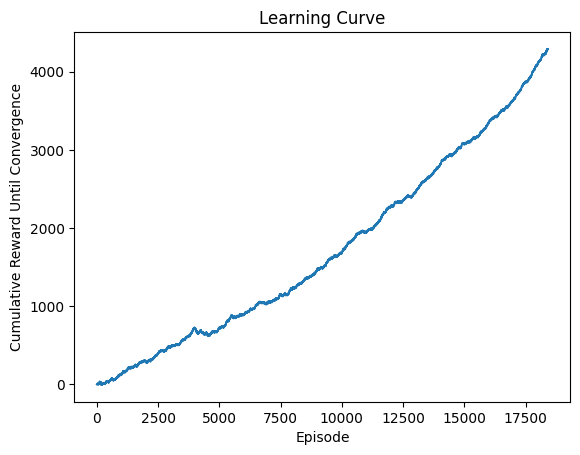

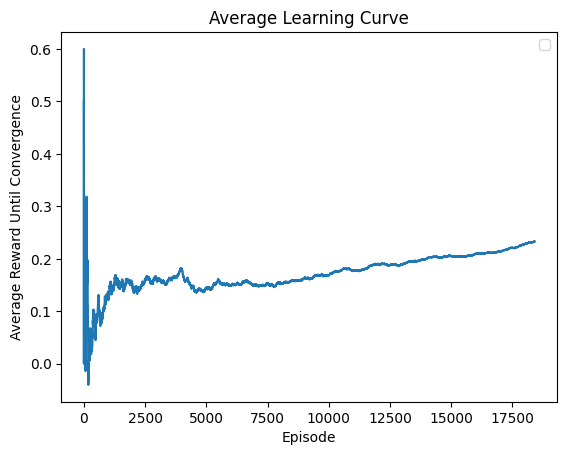

Streaming output truncated to the last 5000 lines.
└─────────┘
Stack at Start:  7.5
In Chips:  1.5
Legal actions: ['fold', 'call']
Action chosen: call

================= Public Cards =================
┌─────────┐   ┌─────────┐
│Q        │   │A        │
│         │   │         │
│         │   │         │
│    ♦    │   │    ♥    │
│         │   │         │
│         │   │         │
│        Q│   │        A│
└─────────┘   └─────────┘
Pot:  5.0 


========= Player:  Threshold Tight Agent  =========
Card: 
┌─────────┐
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
└─────────┘
Stack at Start:  7.5
In Chips:  2.5
Legal actions: ['check', 'bet']
Action chosen: check

========= Player:  Q-Learning Agent  =========
Card: 
┌─────────┐
│K        │
│         │
│         │
│    ♠    │
│         │
│         │
│        K│
└─────────┘
Stack at Start:  32.5
In Chips:  2.5
Legal actions: ['check', 'bet']
Action chosen: bet

========= Player:  Threshold Tight Agent  ==

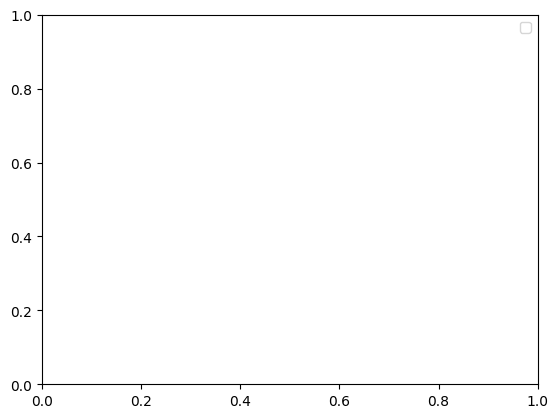

In [67]:
import numpy as np
import matplotlib.pyplot as plt


# from utils import print_card
# from simple_poker_game import SimplePokerGame
# from random_agent import RandomAgent
# from threshold_agent import ThresholdAgent
# from policy_iteration import PolicyIterationAgent
# from simple_player import PlayerStatus
# from q_learning import QLearningAgent
# from human_agent import HumanAgent

player_types = {0: "Random Agent", 1: "Threshold Loose Agent", 2: "Threshold Tight Agent", 3: "Policy Iteration Agent", 4: "Q-Learning Agent", 5: "Human Agent"}

cum_reward_list = []
avg_reward_list = []
players = []

# cummulative_rewards = np.zeros()

"""
    Run an experiment and print the results of each round.
    Args:
        agent: input 0, means Random Agent
               input 1, means Threshold Aggresive
               input 2, means Threshold Defensive
    """
def print_experiment():
    print("================= Simple Hold 'em Variation Example =================")

    #-------------------- Choose Opponents -------------------#
    print("Choose Player One:")
    players_ids = []
    while True:
        p1 = input("0: {:<20} | 1: {:<30} | 2: {:<30} | 3: {:<30}| 4: {:<30} | 5: {:<30}".format(player_types[0], player_types[1], player_types[2], player_types[3], player_types[4], player_types[5]))

        if p1 in ['0', '1', '2', '3', '4', '5']:
            p1 = int(p1)
            players_ids.append(p1)
            break
        else: print("Invalid Input!")

    print("Choose Player Two:")
    while True:
        p2 = input("0: {:<20} | 1: {:<30} | 2: {:<30} | 3: {:<30}| 4: {:<30} | 5: {:<30}".format(player_types[0], player_types[1], player_types[2], player_types[3], player_types[4], player_types[5]))
        if p2 in ['0', '1', '2', '3', '4', '5']:
            p2 = int(p2)
            players_ids.append(p2)
            break
        else: print("Invalid Input!")
    print(f"\n{player_types[p1]} VS {player_types[p2]}")
    input("Press Enter to Start\n")

    #-------------------- Initialize Opponents -------------------#
    for j,i in enumerate(players_ids):
        if i == 0:
            players.append(RandomAgent())
        elif i == 1:
            players.append(ThresholdAgent(aggro = True))
        elif i == 2:
            players.append(ThresholdAgent(aggro = False))
        elif i == 3:
            players.append(PolicyIterationAgent(adversary=players_ids[(j+1)%2]))
        elif i == 4:
            players.append(QLearningAgent(id=j))
        elif i == 5:
            players.append(HumanAgent())


    if player_types[p1] != player_types[p2]:
        game = SimplePokerGame(p1_name = player_types[p1], p2_name = player_types[p2],stacks= 20)
    else:
        game = SimplePokerGame(p1_name = "" + player_types[p1] + "_1", p2_name = "" + player_types[p2] + "_2",stacks= 20)


    # If we have Q-Learning we specify opponent and train
    for i,p in enumerate(players):
        if p.get_type() == "Q-Learning Agent":
            print("Started Training Q-Learning Agent")
            p.train_agent(game,adversary=players[(i+1)%2])
            p.print_q_table()
            input("Training complete. Press Enter")


    #-------------------- Start Game Loop -------------------#
    num_hands_played = 0
    game_on = True
    while game_on:
        # print("\n--------------------------------- Start a new Round ---------------------------------")
        num_hands_played +=1
        game = play_round(num_hands_played, game, players)

        payoffs = game.get_payoffs()

        # Careful problem is policy vs policy are chosen
        for id,p in enumerate(players):
            if p.get_type() == "Policy Iteration Agent" or p.get_type() == "Q-Learning Agent" :
                update_reward_list(payoffs[id])

        # If round over Print Showdown
        print_showdown(game,payoffs)

        # Check if game is over
        if game.is_over():
            game_on = False
            break
        # input('Press Enter to advance to new round!\n\n')
    # When The game is over print the final winner
    print_winner(game)
    plot_rewards()

def update_reward_list(reward):
    cum_reward_list.append(reward) if len(cum_reward_list)==0 else cum_reward_list.append(cum_reward_list[-1] + reward)
    avg_reward_list.append(cum_reward_list[-1]/len(cum_reward_list))


def plot_rewards():
    for p,player in enumerate(players):
        if player.get_type() == "Policy Iteration Agent":
            plt.xlabel("Round")
            plt.ylabel("Cumulative Reward")
            plt.title(f"Cumulative Reward for Policy Iteration Agent")
            plt.plot(np.arange(1, len(cum_reward_list)+1), cum_reward_list, label = 'Policy Cumulative Reward')
            plt.legend()
            plt.show()

            plt.xlabel("Round")
            plt.ylabel("Average Reward per Round")
            plt.title(f"Average Reward for Policy Iteration Agent")
            plt.plot(np.arange(1, len(avg_reward_list)+1), avg_reward_list, label = 'Policy Average Reward')
            plt.legend()
            plt.show()



def play_round(round,game,players):
    print(f"\n\n============================= Round {round} =============================")
    print("\n================= Public Cards =================")
    print_card([None, None])

    # Round starts
    state, _ = game.init_game()
    print("Pot: ", state['pot'],"\n")

    public_printed = False
    while not game.round_over():

        # If not First Round print once the public cards
        if state['round']>0 and not public_printed:
            print("\n================= Public Cards =================")
            print_card(state['public_cards'])
            print("Pot: ", state['pot'],"\n")
            public_printed = True

        # Print the current player's hand
        print("\n========= Player: ", game.players[game.game_pointer].my_name(), " =========")
        # We see only cards of player 0: To simulate being in his side in the table
        print("Card: ")
        print_card(state['hand'] if game.game_pointer == 0 else None)
        print("Stack at Start: ", state['stack'])
        print("In Chips: ", state['my_chips'])

        if len(state['legal_actions']) > 1: # If Someone not All-In. Action
            # input("Press enter for adversary to move")
            print("Legal actions:", state['legal_actions'])
            action = players[game.get_player_id()].step(state)
            print("Action chosen:", action)
        else: # Else. Go on untill round finishes
            action = state['legal_actions'][0]
            print("Simulate to end as player is all in")
        # Proced in game
        state, _, _ = game.step(action)
    return game

def print_winner(game):
    bankrupt_p = 0
    for id, p in enumerate(game.players):
        if p.stack == 0:
            bankrupt_p = id
    print("\n\nThe Player ", game.players[bankrupt_p].my_name() ," Is Bankrupt!\nTherefore The Winner Is ", game.players[(bankrupt_p+1)%2].my_name())
    for p, player in enumerate(players):
        if player.get_type() =="Policy Iteration Agent" or player.get_type() =="Q-Learning Agent":
            print("Average reward at the end of the game for Agent: {:.2f}".format(avg_reward_list[-1]))


    # print(f"Average Cumulative Reward of player: {game.players[0].my_name()} => {res[0]}\nAverage Cumulative Reward of player: {game.players[1].my_name()} => {res[1]}\n")


def print_showdown(game,payoffs):
    ''' Get the perfect information of the current state

    Returns:
        (dict): A dictionary of all the perfect information of the current state
    '''

    print("\n\n==================== Showdown =================")
    state = game.get_state(game.get_player_id())
    print("\nPublic Cards:")
    if state['public_cards']:
        print_card(state['public_cards'])
    else: print_card([None ,None])

    folded_players = [1 if p.status == PlayerStatus.FOLDED else 0 for p in game.players]
    if sum(folded_players) >0:
        print("Winner due to fold")

    print("Player ", game.players[0].my_name()," Hand: ")
    hand = [c.get_index() for c in game.players[0].hand]
    print_card(hand)

    print("Player ", game.players[1].my_name()," Hand: ")
    hand = [c.get_index() for c in game.players[1].hand]
    print_card(hand)


    if np.amax(payoffs) != 0:
        max_index = np.argmax(payoffs)  # Find the maximum value
        print("Player ", game.players[max_index].my_name(), " wins: ", state['all_chips'][(max_index+1)%2])
    else:
        print("Players Split The Pot: To Each Are Returned: ", state['pot']/2)


def main():
    # Set the number of players
    print_experiment()

if __name__ == "__main__":
    main()